In [11]:
import os, sys
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.nn import functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
sys.path.append('/home/hyun_s/CLIP')
import clip
from model import pggan, stylegan2


device = torch.device("cuda:1" if (torch.cuda.is_available()) else "cpu")


print('load model...')
model_path = '/home/hyun_s/Gans/StyleGAN2_featuremap/stylegan/stylegan2_cat256.pth'
G, D= stylegan2(path=model_path, res=256)
G.to(device)
D.to(device)
model, preprocess = clip.load('ViT-B/32', device)

print('models completes')

load model...
/home/hyun_s/.cache/clip/ViT-B-32.pt
models completes


In [12]:
df = pd.read_csv('path_score.csv')
df.head(5)

,image_path,gradient_var
0,/home/hyun_s/Gans/StyleGAN2_featuremap/g_image...,2.186447
1,/home/hyun_s/Gans/StyleGAN2_featuremap/g_image...,1.831537
2,/home/hyun_s/Gans/StyleGAN2_featuremap/g_image...,1.831257
3,/home/hyun_s/Gans/StyleGAN2_featuremap/g_image...,1.534806
4,/home/hyun_s/Gans/StyleGAN2_featuremap/g_image...,1.457732


In [13]:

class G_Dataset(Dataset):
    def __init__(self,df,transform=None):
        # self.img_labels = pd.read_csv(annotations_file)
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx,0]
        image = Image.open(img_path)
        # image = transforms.PILToTensor(image)
        # image = image/255.
        # print(image.shape)
        label = self.df.iloc[idx,1]
        if self.transform:
            image = self.transform(image)
        return image, label

data = G_Dataset(df,transform=preprocess)
dataloader = DataLoader(data,batch_size=256)

In [14]:
all_features = []
all_labels = []
with torch.no_grad():
    for images, vog in tqdm(dataloader):
        features = model.encode_image(images.to(device))
        all_features.append(features)
        all_labels.append(vog)
        s = images
feature,vog = torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

100%|██████████| 157/157 [15:57<00:00,  6.10s/it]


In [7]:
all_features = []
all_labels = []
all_features_t = []
with torch.no_grad():
    for images, vog in tqdm(dataloader):
        features = model.encode_image(images.to(device))
        text = torch.cat([clip.tokenize('a photo of cat') for x in range(len(vog))]).to(device)
        text_features = model.encode_text(text)
        all_features.append(features)
        all_labels.append(vog)
        all_features_t.append(text_features)

image_features = torch.cat(all_features)
text_features = torch.cat(all_features_t)
labels = torch.cat(all_labels)

# image_features /= image_features.norm(dim=-1, keepdim=True)
# text_features /= text_features.norm(dim=-1, keepdim=True)
# similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
# values, indices = similarity[0].topk(5)


100%|██████████| 157/157 [11:04<00:00,  4.24s/it]


/home/hyun_s/anaconda3/envs/env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hyun_s/anaconda3/envs/env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


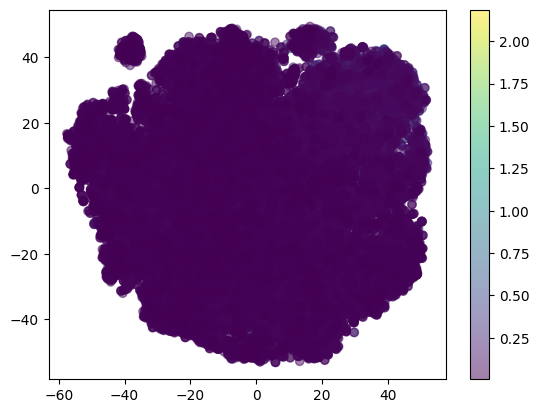

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(2)

x = (tsne.fit_transform(feature))
        # plt.figure(figsize = (10, 7))
plt.scatter(x[:,0],x[:,1],c=vog,alpha=0.5)
plt.colorbar()

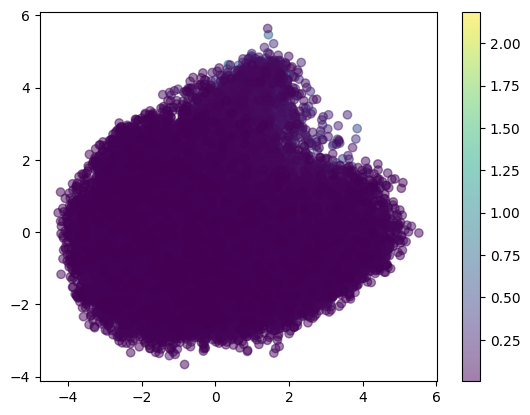

In [16]:
from sklearn.decomposition import PCA
pca = PCA(2)
x = (pca.fit_transform(feature))
        # plt.figure(figsize = (10, 7))
plt.scatter(x[:,0],x[:,1],c=vog,alpha=0.5)
plt.colorbar()

In [95]:
pca.components_

array([[ 1.58875777e-02,  3.28651972e-02, -2.02223842e-02, ...,
         4.19825345e-03,  7.59382613e-04,  3.94688130e-03],
       [ 3.56002284e-03, -7.44180137e-03, -7.35769067e-03, ...,
        -2.87341911e-02, -1.44605322e-02, -1.71264993e-02],
       [ 1.60352026e-02, -1.77543056e-02, -7.76014788e-03, ...,
         3.61346691e-02, -2.35634771e-02, -1.73157946e-02],
       ...,
       [-1.45622452e-02,  6.48264919e-03,  2.13647290e-02, ...,
         3.57824730e-02,  8.95444482e-03,  5.31847551e-03],
       [-5.43845564e-02, -2.58377405e-02,  2.27052771e-02, ...,
         9.41921501e-02,  1.55880098e-04,  2.37425794e-02],
       [-1.84481770e-04, -1.94092747e-04,  7.88220094e-05, ...,
        -2.78419829e-04, -5.47811166e-05,  1.43932158e-05]])

In [ ]:
feature_2d = tsne.fit_transform(feature)
